# Back-testing Simulator

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from utils.util import get_data, plot_data, get_bollinger_bands
import matplotlib.pyplot as plt
from itertools import izip
%matplotlib inline

### Initialization

In [2]:
date_start = '2007-12-31'
date_end = '2009-12-31'
folder_strategy = 'out'
file_strategy = 'bollingerstrategy' 
stock = 'IBM'

dates = pd.date_range(date_start, date_end)
file_name = os.path.join(folder_strategy, '{}.csv'.format(file_strategy))

### Load Data

In [3]:
# Load orders
orders = pd.read_csv(file_name, index_col=0, parse_dates=True)
orders.head()

,Symbol,Order,Shares,Price
Date,,,,
2008-07-01,IBM,BUY,5,110.40
2008-07-08,IBM,SELL,5,114.67
2008-08-21,IBM,BUY,5,114.29
2008-09-19,IBM,SELL,5,110.44
2008-10-10,IBM,BUY,5,81.54


In [4]:
# Load stock data and join orders in the same DataFrame 
prices_all = get_data([stock], dates)
df = prices_all[[stock]]
df = df.join(orders[['Order', 'Shares']])
df.head()

,IBM,Order,Shares
2007-12-31,99.27,NaN,NaN
2008-01-02,96.14,NaN,NaN
2008-01-03,96.34,NaN,NaN
2008-01-04,92.87,NaN,NaN
2008-01-07,91.88,NaN,NaN


### Back-Testing

In [31]:
df['daily_val'] = 0.0
hold = False

# Compute portfolio daily value
for i, row in df.iterrows():
    
    if row['Order'] == 'BUY':
        hold = True
        n_stocks = row['Shares']
    
    if hold == True:
        df.loc[i, 'Shares'] = n_stocks # replicate shares when stock is hold
        df.loc[i, 'daily_val'] = n_stocks * row[stock]

    if row['Order'] == 'SELL':
        hold = False

# Compute daily returns
df['daily_return'] = df['daily_val'].diff()        
# Reset to 0 not valid daily_returns  
for (index1, row1),(index2, row2) in izip(df.iterrows(), df[1:].iterrows()):
    if np.isnan(row1['Shares']) or np.isnan(row2['Shares']):
        df.loc[index2, 'daily_return'] = 0.0
df['cum_return'] = df['daily_return'].cumsum()

# Compute cumulative portfolio value
T0 = df[df['Order']=='BUY'].index[0] # Timestamp @ first investment 
Val0 = df.ix[T0]['daily_val'] # Initial portfolio value
df['port_val'] = df['cum_return'] + Val0
df.loc[:df.index.get_loc(T0), 'port_val'] = np.nan

df.head()      

,IBM,Order,Shares,daily_val,daily_return,cum_return,port_val
2007-12-31,99.27,NaN,NaN,0.0,NaN,NaN,NaN
2008-01-02,96.14,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-03,96.34,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-04,92.87,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-07,91.88,NaN,NaN,0.0,0.0,0.0,NaN


### Print Results

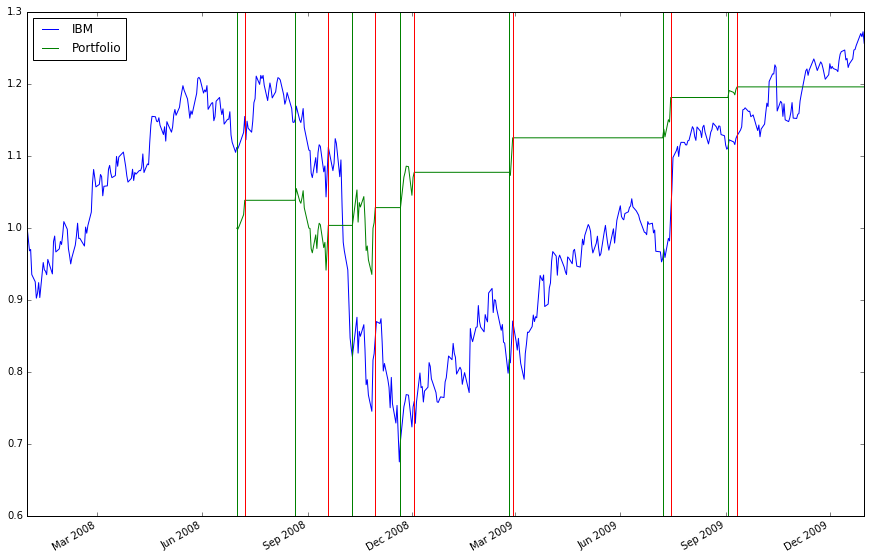

In [6]:
df_temp = pd.concat([df[stock]/df.ix[0][stock], df['port_val']/df.ix[T0]['port_val']], keys=[stock, 'Portfolio'], axis=1)
#plot_data(df_temp)
ax = df_temp.plot(figsize=(15, 10))

# Plot Bollinger Strategy
for day, key in orders.iterrows():
    if key['Order'] == 'BUY':
        ax.axvline(x=day, color='green')
    elif key['Order'] == 'SELL':
        ax.axvline(x=day, color='red')

In [14]:
df.head()

,IBM,Order,Shares,daily_val,daily_return,cum_return,port_val
2007-12-31,99.27,NaN,NaN,0.0,NaN,NaN,NaN
2008-01-02,96.14,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-03,96.34,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-04,92.87,NaN,NaN,0.0,0.0,0.0,NaN
2008-01-07,91.88,NaN,NaN,0.0,0.0,0.0,NaN


In [30]:
from utils.util import compute_daily_returns, compute_sharpe_ratio, compute_cumulative_returns
daily_ret = compute_daily_returns(df['port_val'])
compute_sharpe_ratio(df['port_val'])
compute_cumulative_returns(df['port_val'])

nan